# Introduction

One of our clients is a company that focuses in content creation around the topic of data science. They want to know what kind of questions are popular so that they can publish content that resonates with their audience. The [link Stack Exchange Data Science database](https://data.stackexchange.com/datascience/query/new) is a good source of information that could help our clients make an informed decision.

## First impressions

By taking a quick look at the website's [link Data Science section](https://datascience.stackexchange.com/?tab=hot), it looks like deep learning has and still is a very popular topic. This means that it could be interesting for the company to spend more time creating more content around it.

## Database Query
 
We are going to use the `Posts` database from Stack Exchange to retrieve the information we deem necessary. We are mainly interested in the questions, so that's what we are going to be focusing on. To query the database we need to use Transact-SQL.

We run the following query to extract the questions that were ask in 2019.

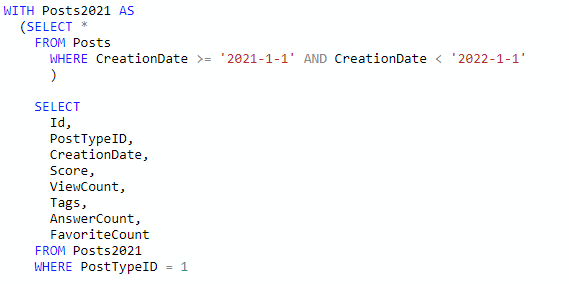

## Cleaning the dataset

In [17]:
#Importing the libraries we are going to need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
#Enabling plotting within the notebook
%matplotlib inline

#Reading the csv file that we obtained from the database
questions = pd.read_csv("2021_questions.csv")
print(questions.head())

      Id  PostTypeID         CreationDate  Score  ViewCount  \
0  87593           1  2021-01-06 16:11:35      1         99   
1  88373           1  2021-01-23 15:21:49      1         80   
2  89414           1  2021-02-15 21:13:14      1         69   
3  90368           1  2021-03-08 07:04:29      1         98   
4  90553           1  2021-03-12 12:21:47      1         28   

                                                Tags  AnswerCount  \
0  <machine-learning><dimensionality-reduction><m...            0   
1     <random-forest><prediction><survival-analysis>            0   
2           <cnn><dimensionality-reduction><pruning>            0   
3        <convolutional-neural-network><convolution>            0   
4                <cnn><convolutional-neural-network>            0   

   FavoriteCount  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  


It looks like the `FavoriteCount` column has a lot of NaN values. Let's see if other columns have null values as well.

In [18]:
print(questions.isnull().sum())

Id                  0
PostTypeID          0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    4598
dtype: int64


In [19]:
questions.shape

(4598, 8)

The only column that has null values is `FavoriteCount` which logs the number of times each post has been favorited. It seems to also affect all the rows of the dataset. Since it doesn't provide us with any value, we are just going to drop that column. 

In [20]:
questions = questions.drop("FavoriteCount", axis=1)

In [21]:
print(questions.head())

      Id  PostTypeID         CreationDate  Score  ViewCount  \
0  87593           1  2021-01-06 16:11:35      1         99   
1  88373           1  2021-01-23 15:21:49      1         80   
2  89414           1  2021-02-15 21:13:14      1         69   
3  90368           1  2021-03-08 07:04:29      1         98   
4  90553           1  2021-03-12 12:21:47      1         28   

                                                Tags  AnswerCount  
0  <machine-learning><dimensionality-reduction><m...            0  
1     <random-forest><prediction><survival-analysis>            0  
2           <cnn><dimensionality-reduction><pruning>            0  
3        <convolutional-neural-network><convolution>            0  
4                <cnn><convolutional-neural-network>            0  


In [22]:
#Print datatypes of the columns
print(questions.dtypes)

Id               int64
PostTypeID       int64
CreationDate    object
Score            int64
ViewCount        int64
Tags            object
AnswerCount      int64
dtype: object


In [23]:
#Transform the CreationDate column into a datetime column
questions["CreationDate"] = pd.to_datetime(questions["CreationDate"])

In [24]:
print(questions["CreationDate"].dtypes)

datetime64[ns]


In [25]:
#Change the Tags column to have a more natural syntaxis
questions["Tags"] = questions["Tags"].str[0:-1].str.replace("<","").str.replace(">",",")

In [26]:
print(questions["Tags"].head())

0    machine-learning,dimensionality-reduction,mani...
1           random-forest,prediction,survival-analysis
2                 cnn,dimensionality-reduction,pruning
3             convolutional-neural-network,convolution
4                     cnn,convolutional-neural-network
Name: Tags, dtype: object


In [27]:
#We want to find out how many times each tag was used to do that we need to split the tags on the comma
tags = questions["Tags"].str.split(",")
print(tags.head())

0    [machine-learning, dimensionality-reduction, m...
1       [random-forest, prediction, survival-analysis]
2             [cnn, dimensionality-reduction, pruning]
3          [convolutional-neural-network, convolution]
4                  [cnn, convolutional-neural-network]
Name: Tags, dtype: object


The tags have now been split into individual tags. Now we want to be able to count each of their occurrences. To do so we are going to create a dictionary that stores the number of times that each tag is mentioned. Since each row now contains a list, we will need to create a nested loop within the original loop. Since we also want to know how many times the tag was viewed, we will take advantage of the loop and get that information at the same time.

In [28]:
#create an empty dictionary to store the count of each of the tags
used_tags = {}
views = questions["ViewCount"]
view_counter = {}

for t,v in zip(tags, views):
    for tag in t:
        if tag in used_tags:
            used_tags[tag] +=1
            view_counter[tag] += v 
        else:
            used_tags[tag] = 1
            view_counter[tag] = v


In [29]:
#Convert dictionaries into a dataframe of the 10 most used tags
tag_counts = pd.Series(used_tags)
view_number = pd.Series(view_counter)
top_10_tags = pd.DataFrame({"Times used": tag_counts,"Times viewed": view_number}).sort_values("Times used", ascending = False).head(10)

In [30]:
print(top_10_tags)

                  Times used  Times viewed
machine-learning        1277        827793
python                   884       1043504
deep-learning            670        538457
neural-network           425        261987
nlp                      404        294406
classification           397        182093
keras                    347        376993
tensorflow               324        357731
scikit-learn             295        327462
time-series              248        114705


We can now see that `machine-learning`, `python`, `deep-learning` and `neural network` are extremely popular. However, the ranking on most times used, it is not the same as the most times viewed, with `python` having been viewed more than `machine-learning´

## Data visualisation

To better underestand the rankings we are going to create some horizontal bar charts.

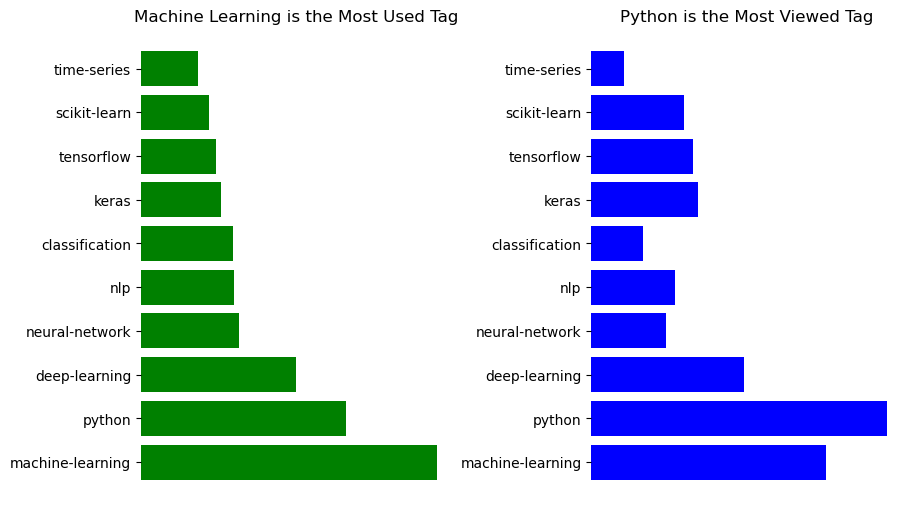

In [31]:
tick_names = top_10_tags.index #store index of dataframe for y-axis labels
width = .34 #width of horizontal bars
sides = ["top", "bottom", "right", "left"] #list used to turn off chart spines

fig,(ax1,ax2) = plt.subplots(1,2, figsize = (9,5), layout ="constrained")

ax1.barh(tick_names, top_10_tags["Times used"], color ="green")
for s in sides:
    ax1.spines[s].set_visible(False)
ax1.set_xticks([])
ax1.set_title("Machine Learning is the Most Used Tag")

ax2.barh(tick_names, top_10_tags["Times viewed"], color = "Blue")
for s in sides:
    ax2.spines[s].set_visible(False)
ax2.set_xticks([])
ax2.set_title("Python is the Most Viewed Tag")

plt.show()


We can now clearly see that although `Machine learning` is the most used tags, `Python` is actually the most viewed tag. However, the top five most used tags are also the top 5 most viewed tags.

## Is the interest in deep learning just a fad?

We now want to know if the interest in deep learning is only something temporary or if it actually is something people have been interested in, for a long time. To do so we are going to export all the questions ever asked on DSSE during 2019.

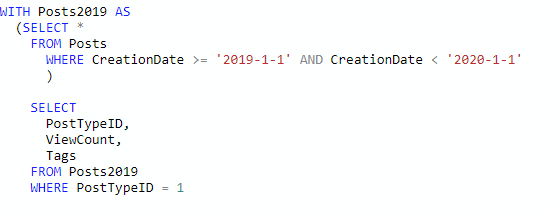

In [32]:
questions2019 = pd.read_csv("2019_questions.csv")
print(questions2019.head())

   PostTypeID  ViewCount                                               Tags
0           1         34        <deep-learning><nlp><lstm><text-generation>
1           1         74  <neural-network><deep-learning><time-series><a...
2           1        620              <machine-learning><time-series><java>
3           1        192                <data-mining><text-mining><ranking>
4           1        120  <deep-learning><keras><gradient-descent><mathe...


In [33]:
print(questions2019.shape)

(6610, 3)


In [34]:
print(questions2019.isnull().sum())

PostTypeID    0
ViewCount     0
Tags          0
dtype: int64


In [35]:
questions2019=questions2019.drop("PostTypeID", axis=1)

In [36]:
print(questions2019.head())

   ViewCount                                               Tags
0         34        <deep-learning><nlp><lstm><text-generation>
1         74  <neural-network><deep-learning><time-series><a...
2        620              <machine-learning><time-series><java>
3        192                <data-mining><text-mining><ranking>
4        120  <deep-learning><keras><gradient-descent><mathe...


In [37]:
questions2019["Tags"] = questions2019["Tags"].str[0:-1].str.replace("<","").str.replace(">",",")
print(questions2019.head())

   ViewCount                                               Tags
0         34             deep-learning,nlp,lstm,text-generation
1         74  neural-network,deep-learning,time-series,anoma...
2        620                  machine-learning,time-series,java
3        192                    data-mining,text-mining,ranking
4        120   deep-learning,keras,gradient-descent,mathematics


In [38]:
tags_2019 = questions2019["Tags"].str.split(",")

In [39]:
print(tags_2019.head())

0          [deep-learning, nlp, lstm, text-generation]
1    [neural-network, deep-learning, time-series, a...
2                [machine-learning, time-series, java]
3                  [data-mining, text-mining, ranking]
4    [deep-learning, keras, gradient-descent, mathe...
Name: Tags, dtype: object


In [40]:
views2019 = questions2019["ViewCount"]
used_tags2019 = {}
view_counter2019 = {}

for t,v in zip(tags_2019,views2019):
    for tag in t:
        if tag in used_tags2019:
            used_tags2019[tag] += 1
            view_counter2019[tag] += v
        else:
            used_tags2019[tag] = 1
            view_counter2019[tag] = v

In [41]:
tag_counts2019 = pd.Series(used_tags2019)
view_counts2019 = pd.Series(view_counter2019)
top_10_tags2019 = pd.DataFrame({"Times used":tag_counts2019, "Times viewed":view_counts2019}).sort_values("Times used", ascending=False).head(10)

In [42]:
print(top_10_tags2019)

                  Times used  Times viewed
machine-learning        2082       3515320
python                  1412       4571331
deep-learning            869       1955755
neural-network           805       1847412
keras                    686       1947984
classification           565        942147
scikit-learn             440       1294285
nlp                      436        821551
tensorflow               397       1062943
cnn                      373        805221


By the looks of it things in 2021 were very similar to those in 2019. The overall volume of questions might have been different, but the top 10 topics are still very similar.

In [43]:
most_used = pd.merge (top_10_tags, top_10_tags2019, how="outer", left_index=True, right_index=True)

In [44]:
print(most_used)

                  Times used_x  Times viewed_x  Times used_y  Times viewed_y
classification           397.0        182093.0         565.0        942147.0
cnn                        NaN             NaN         373.0        805221.0
deep-learning            670.0        538457.0         869.0       1955755.0
keras                    347.0        376993.0         686.0       1947984.0
machine-learning        1277.0        827793.0        2082.0       3515320.0
neural-network           425.0        261987.0         805.0       1847412.0
nlp                      404.0        294406.0         436.0        821551.0
python                   884.0       1043504.0        1412.0       4571331.0
scikit-learn             295.0        327462.0         440.0       1294285.0
tensorflow               324.0        357731.0         397.0       1062943.0
time-series              248.0        114705.0           NaN             NaN


In [47]:
most_used = most_used.rename({"Times used_x":"Times used_2021","Times used_y":"Times used_2019","Times viewed_x":"Times viewed_2021", "Times viewed_y":"Times viewed_2019"}, axis=1).sort_values("Times used_2021",ascending=False)

In [48]:
print(most_used)

                  Times used_2021  Times viewed_2021  Times used_2019  \
machine-learning           1277.0           827793.0           2082.0   
python                      884.0          1043504.0           1412.0   
deep-learning               670.0           538457.0            869.0   
neural-network              425.0           261987.0            805.0   
nlp                         404.0           294406.0            436.0   
classification              397.0           182093.0            565.0   
keras                       347.0           376993.0            686.0   
tensorflow                  324.0           357731.0            397.0   
scikit-learn                295.0           327462.0            440.0   
time-series                 248.0           114705.0              NaN   
cnn                           NaN                NaN            373.0   

                  Times viewed_2019  
machine-learning          3515320.0  
python                    4571331.0  
deep-lear

## Conclusion
The most popular topics have been consistent over the years.